## **Importação das bibliotecas e dados (AEP e Duas Unas)**

In [23]:
# %pip install ipykernel --break-system-packages
# %pip install scikit-learn --break-system-packages
# %pip install matplotlib --break-system-packages
# %pip install keras --break-system-packages
# %pip install tensorflow --break-system-packages
# %pip install pandas --break-system-packages
# %pip install plotly --break-system-packages
# %pip install seaborn --break-system-packages
# %pip install nbformat --break-system-packages
# %pip install keras --break-system-packages
# %pip install pswarm


In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

base_path = './dataset/'
time_base = 'days'
duas_unas_dataset = f'{base_path}duas_unas/{time_base}/grouped_1_{time_base}.csv'
validation_interval = 61 
time_step = 1
output_steps = 60

##### SETUP VARIABLES
hyperparameter_boundaries = [
    (10, 200), 
    (0.1, 0.4), 
    (0.00001, 0.005), 
    (16, 64),
    (10000, 10000), 
    (2, 8),
    (1, 5),
    (1,1),
    (1,1),
    (0,0)
]
def return_particles_to_consider(particle):
    return {
        "units" : int(particle[0]),
        "dropout_rates" : particle[1],
        "learning_rate" : particle[2],
        "batch_size" : int(particle[3]),
        "epochs" : int(particle[4]),
        "patience" : int(particle[5]),
        "num_camadas_LSTM" : int(particle[6]),
        "activation_idx" : int(particle[7]),
        "loss_idx" : int(particle[8]),
        "optimizer_idx" : int(particle[9]),
    }


In [25]:
duas_unas_df = pd.read_csv(duas_unas_dataset)  

duas_unas_validation = duas_unas_df.tail(validation_interval)  

indices_to_validate = duas_unas_df.index[-validation_interval:].tolist()  
duas_unas_df = duas_unas_df.drop(indices_to_validate).reset_index(drop=True)  

duas_unas_df['timestamp'] = pd.to_datetime(duas_unas_df['timestamp'])  
duas_unas_validation['timestamp'] = pd.to_datetime(duas_unas_validation['timestamp'])  

duas_unas_df['index'] = range(len(duas_unas_df))  
duas_unas_validation['index'] = indices_to_validate  
duas_unas_df['kwh'] = duas_unas_df['kWh fornecido']  
duas_unas_validation['kwh'] = duas_unas_validation['kWh fornecido']  

duas_unas_df.drop(columns=['timestamp'], inplace=True) 
duas_unas_validation.drop(columns=['timestamp'], inplace=True)  

duas_unas_df.drop(columns=['kWh fornecido'], inplace=True)  
duas_unas_validation.drop(columns=['kWh fornecido'], inplace=True)  

X = duas_unas_df['index'].values.reshape(-1,1)  
y = duas_unas_df['kwh'].values  

X_validation = duas_unas_validation['index'].values.reshape(-1,1)  
y_validation = duas_unas_validation['kwh'].values

In [26]:
def identify_peaks_and_valleys(y_test):
    weights = tf.ones(tf.shape(y_test), dtype=tf.float32)

    mask = tf.size(y_test) < 3

    def process_peaks_and_valleys():

        y_test_float = tf.cast(y_test, tf.float32)
        y_test_prev = tf.concat([tf.expand_dims(y_test_float[0], axis=0), y_test_float[:-1]], axis=0)
        y_test_next = tf.concat([y_test_float[1:], tf.expand_dims(y_test_float[-1], axis=0)], axis=0)

        peaks = tf.where((y_test_float > y_test_prev) & (y_test_float > y_test_next))
        valleys = tf.where((y_test_float < y_test_prev) & (y_test_float < y_test_next))

        weights_updated = tf.tensor_scatter_nd_update(weights, peaks, tf.fill(tf.shape(peaks)[:1], 2.0))
        weights_updated = tf.tensor_scatter_nd_update(weights_updated, valleys, tf.fill(tf.shape(valleys)[:1], 2.0))

        return weights_updated

    weights = tf.cond(mask, lambda: weights, process_peaks_and_valleys)

    return weights

In [27]:
def wmse(y_test, y_pred):
    y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)
    y_pred = tf.convert_to_tensor(y_pred, dtype=tf.float32)

    weights = identify_peaks_and_valleys(y_test)

    wmse_value = (tf.reduce_sum(weights * tf.square(y_test - y_pred)) / tf.reduce_sum(weights))

    return wmse_value

In [28]:
def wmae(y_test, y_pred):
    y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)
    y_pred = tf.convert_to_tensor(y_pred, dtype=tf.float32)

    weights = identify_peaks_and_valleys(y_test)

    wmae_value = (tf.reduce_sum(weights * tf.abs(y_test - y_pred)) / tf.reduce_sum(weights))

    return wmae_value

In [29]:
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_kwh = scaler.fit_transform(duas_unas_df['kwh'].values.reshape(-1, 1)) 

scaled_kwh_validation = scaler.fit_transform(duas_unas_validation['kwh'].values.reshape(-1,1)) 

def create_dataset(data, time_step, output_steps): 
    X, y = [], [] 
    for i in range(len(data) - time_step - output_steps + 1): 
        X.append(data[i:(i + time_step), 0]) 
        y.append(data[(i + time_step):(i + time_step + output_steps), 0])
    return np.array(X), np.array(y)

X, y = create_dataset(scaled_kwh, time_step, output_steps)

X_validation, y_validation = create_dataset(scaled_kwh_validation, time_step, output_steps)

X = X.reshape(X.shape[0], X.shape[1], 1)
X_validation = X_validation.reshape(X_validation.shape[0], X_validation.shape[1], 1)

In [30]:
def fitness_function(particle):    
    parameters = return_particles_to_consider(particle)

    loss_options = [wmse, wmae, "mean_squared_error", "mean_absolute_error"]
    optimizer_options = ["adam", "rmsprop", "sgd"]
    activation_options = ["tanh", "relu", "sigmoid"]

    loss = loss_options[parameters['loss_idx']]
    optimizer = optimizer_options[parameters['optimizer_idx']]
    activation = activation_options[parameters['activation_idx']]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    model = Sequential()

    for _ in range(int(parameters['num_camadas_LSTM'])):
        model.add(LSTM(int(parameters['units']), return_sequences=True if _ < int(parameters['num_camadas_LSTM']) - 1 else False, input_shape=(X_train.shape[1], 1)))

        model.add(Dropout(parameters['dropout_rates']))

    model.add(Dense(output_steps, activation=activation))

    if optimizer == 'adam':
        opt = Adam(learning_rate=parameters['learning_rate'])
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=parameters['learning_rate'])
    else:
        opt = SGD(learning_rate=parameters['learning_rate'])

    model.compile(optimizer=opt, loss=loss)

    early_stopping = EarlyStopping(monitor='val_loss', patience=parameters['patience'], restore_best_weights=True)

    history = model.fit(X_train, y_train, batch_size=parameters['batch_size'], epochs=int(100000), validation_data=(X_validation, y_validation), 
                        verbose=0, callbacks=[early_stopping])
    
    plt.plot(history.history['loss'], label='Loss de Treinamento')
    plt.plot(history.history['val_loss'], label='Loss de Validação')
    plt.xlabel('Épocas')
    plt.ylabel('Perda')
    plt.legend()
    plt.show()
    
    return model.evaluate(X_validation, y_validation), model


/home/joaotinoco/.local/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


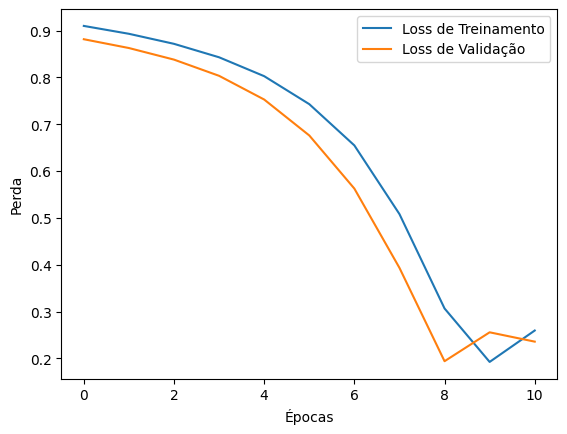

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.1941
best_score_until_now 0.1940663605928421
Melhor solução encontrada até agora: [2.99779852e+01 1.10560527e-01 4.41096763e-03 4.56908148e+01
 1.00000000e+04 2.62386424e+00 3.76467348e+00 1.00000000e+00
 1.00000000e+00 0.00000000e+00]


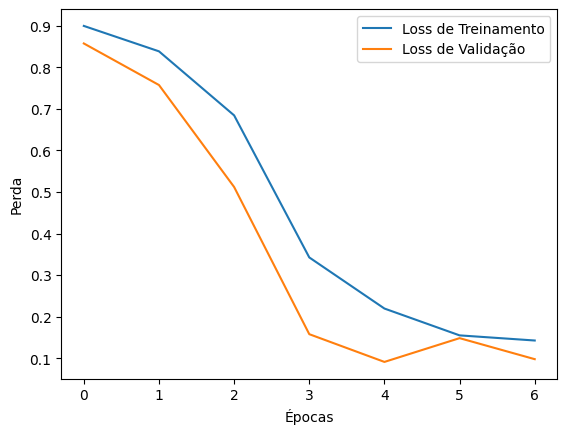

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0910
best_score_until_now 0.09102966636419296
Melhor solução encontrada até agora: [9.06842903e+01 3.63522609e-01 1.90830743e-03 1.62450834e+01
 1.00000000e+04 2.53675589e+00 2.25532315e+00 1.00000000e+00
 1.00000000e+00 0.00000000e+00]


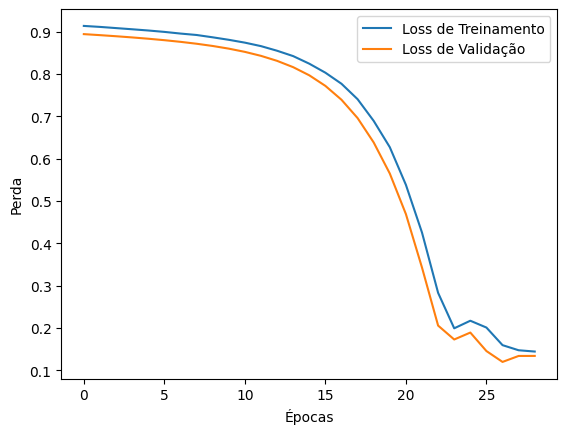

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.1199


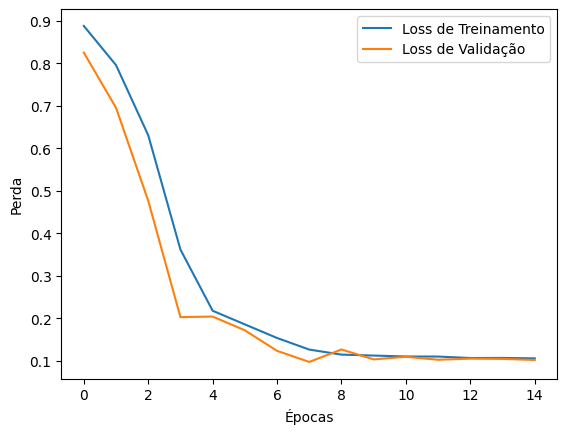

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0972


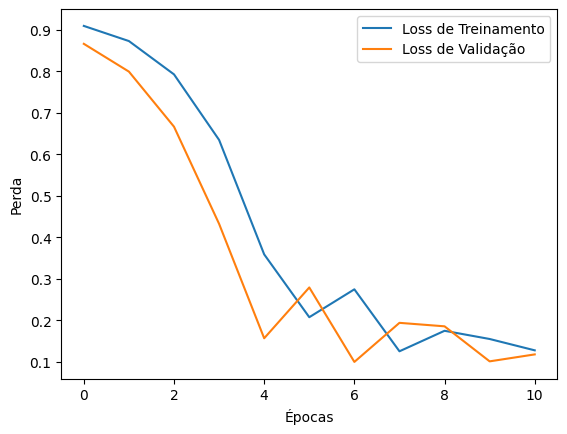

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.1003


In [ ]:
n_particles = 15   
n_iterations = 30  
w = 0.5            
c1 = 0.5           
c2 = 0.5           

particles = np.random.rand(n_particles, len(hyperparameter_boundaries))
particles = particles * (np.array([ub - lb for lb, ub in hyperparameter_boundaries])) + np.array([lb for lb, ub in hyperparameter_boundaries])

velocities = np.random.rand(n_particles, len(hyperparameter_boundaries))
pbest_positions = particles.copy()
pbest_scores = [float('inf')] * n_particles
gbest_position = None
gbest_score = np.inf

def update_particles(particles, velocities):
    for i in range(n_particles):
        velocities[i] = w * velocities[i] + c1 * np.random.rand() * (pbest_positions[i] - particles[i]) + c2 * np.random.rand() * (gbest_position - particles[i])
        particles[i] += velocities[i]
        particles[i] = np.clip(particles[i], [lb for lb, ub in hyperparameter_boundaries], [ub for lb, ub in hyperparameter_boundaries])

for iteration in range(n_iterations):
    for i in range(n_particles):
        score, model = fitness_function(particles[i]) 
        
        if score < pbest_scores[i]:
            pbest_scores[i] = score
            pbest_positions[i] = particles[i].copy()

        if score < gbest_score:
            gbest_score = score
            gbest_position = particles[i].copy()
            print(f"best_score_until_now", gbest_score)
            print("Melhor solução encontrada até agora:", gbest_position)
            best_model = model

    update_particles(particles, velocities)

print("Melhor solução encontrada:", gbest_position)
print("Melhor score:", gbest_score)

In [ ]:
print("Melhor solução encontrada:", gbest_position)
print("Melhor score:", gbest_score)
print("Modelo", model)

In [4]:
def avaliacao_multistep(janela_real, janela_prevista):
    mae_med = 0
    mse_med = 0
    rmse_med = 0
    mape_med = 0
    acuracia_med = 0

    for j in range(len(janela_prevista)):
        if len(janela_real) != len(janela_prevista):
            raise ValueError("As janelas reais e previstas devem ter o mesmo comprimento.")
        else:
            mae = round(mean_absolute_error(janela_real[j], janela_prevista[j]), 3)
            print("MAE(Erro absoluto médio) Score of LSTM model = ",mae)

            mse = round(mean_squared_error(janela_real[j], janela_prevista[j]), 3)
            print("MSE(Erro quadrático médio) Score of LSTM model = ",mse)
            
            rmse = round(np.sqrt(mse), 3)
            print("RMSE(Raiz do erro quadrático médio) Score of LSTM model = ",rmse)

            mape = round(mean_absolute_percentage_error(janela_real[j], janela_prevista[j]), 2)
            print("MAPE(Erro percentual médio absoluto) Score of LSTM model = ",mape)
            
            diferencas_percentuais = np.abs((np.array(janela_real[j]) - np.array(janela_prevista[j])) / np.array(janela_real[j]))

            acertos = np.sum(diferencas_percentuais <= 0.05)

            acuracia = acertos / len(janela_real[0])   
            acuracia = round(100 * acuracia, 2)
            
            mae_med += mae
            mse_med += mse
            rmse_med += rmse
            mape_med += mape
            acuracia_med += acuracia
            
    mae_med = mae_med/(len(janela_prevista))
    mse_med /=(len(janela_prevista))
    rmse_med /=(len(janela_prevista))
    mape_med /=(len(janela_prevista))
    acuracia_med /=(len(janela_prevista))
    
    return round(mae_med,2), round(mse_med,2), round(rmse_med,2), round(mape_med,2), round(acuracia_med,2)

In [ ]:
y_pred = model.predict(X_validation)
print(len(X_validation), len(y_pred), len(X_validation[0]))
y_pred_rescaled = scaler.inverse_transform(y_pred)

y_test_rescaled = scaler.inverse_transform(y_validation)
#indices_to_validate = indices_to_validate[:len(y_pred_rescaled)]
indices_to_validate = indices_to_validate[:validation_interval]
print(indices_to_validate)

plt.figure(figsize=(8,6))
plt.plot(indices_to_validate[0:output_steps], y_test_rescaled[0], label="Original", color='blue')
plt.plot(indices_to_validate[0:output_steps], y_pred_rescaled[0], label="Predição", color='red')
plt.yticks(np.arange(0,200000,step=10000))
plt.show()

plt.figure(figsize=(8,6))
plt.plot(indices_to_validate[1:1+output_steps], y_test_rescaled[1], label="Original", color='blue')
plt.plot(indices_to_validate[1:1+output_steps], y_pred_rescaled[1], label="Predição", color='red')
plt.yticks(np.arange(0,200000,step=10000))
plt.show()


plt.figure(figsize=(8,6))
plt.plot(indices_to_validate[2:2+output_steps], y_test_rescaled[2], label="Original", color='blue')
plt.plot(indices_to_validate[2:2+output_steps], y_pred_rescaled[2], label="Predição", color='red')
plt.yticks(np.arange(0,200000,step=10000))
plt.show()


plt.figure(figsize=(8,6))
plt.plot(indices_to_validate[3:3+output_steps], y_test_rescaled[3], label="Original", color='blue')
plt.plot(indices_to_validate[3:3+output_steps], y_pred_rescaled[3], label="Predição", color='red')
plt.yticks(np.arange(0,200000,step=10000))
plt.show()


plt.figure(figsize=(8,6))
plt.plot(indices_to_validate[4:4+output_steps], y_test_rescaled[4], label="Original", color='blue')
plt.plot(indices_to_validate[4:4+output_steps], y_pred_rescaled[4], label="Predição", color='red')
plt.yticks(np.arange(0,200000,step=10000))
plt.show()


In [ ]:
avaliacao_multistep(y_test_rescaled,y_pred_rescaled)